In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# **Info 159: Model**

This notebook contains our model code. Run the cells in order to reproduce results. NOTE: `all_500_annotations.csv` is saved as `adjudicated.txt` file, it will need to be processed as CSV for our code to run.

In [3]:
df1 = pd.read_csv("/content/all_500_annotations.csv")
df = df1[["Text", "Final_Label"]]
df.head()

,Text,Final_Label
0,so that when the Court of Arbitration nominat...,E
1,"$24,400,997.38, and expenditures, exclusive of...",E
2,"18,000 are engaged in the Coast Artillery and ...",E
3,1919. This has been a normal and natural appli...,E
4,23 million school children under the Safe and ...,CTA


In [4]:
# Build Model
X = df['Text'].values
y = df['Final_Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=159)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=159)

# Sanity check
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_dev: {X_dev.shape}, y_dev: {y_dev.shape}")

X_train: (300,), y_train: (300,)
X_test: (100,), y_test: (100,)
X_dev: (100,), y_dev: (100,)


## **BERT Model**

In [5]:
!pip install transformers
!pip install torch --upgrade
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [6]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [7]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1
    return corr/total, total

In [8]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()

        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)

        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)
        #self.device = device  # Store device as an instance variable

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):

        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]

        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(self.device))
            batches_y.append(torch.LongTensor(batch_y).to(self.device))

        return batches_x, batches_y


    def forward(self, batch_x):

        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.

        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [9]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [10]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert_model.to(device)
    bert_model.device = device

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-4)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _ = evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model


In [11]:
# Sanity check
labels = df['Final_Label'].unique()
len(labels)

9

In [12]:
X_train1 = [' '.join(x) if isinstance(x, list) else x for x in X_train]
X_dev1 = [' '.join(x) if isinstance(x, list) else x for x in X_dev]
label2id = {label: idx for idx, label in enumerate(labels)}
y_train1 = [label2id[y] for y in y_train]
y_dev1 = [label2id[y] for y in y_dev]

In [13]:
torch.cuda.empty_cache()

# small BERT -- can run on laptop
bert_model_name="google/bert_uncased_L-2_H-128_A-2"
model_filename="mybert.model"
embedding_size=128
doLowerCase=True

# bert-base -- slow on laptop; better on Colab
# bert_model_name="bert-base-cased"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=False

model=train(bert_model_name, model_filename, X_train1, y_train1, X_dev1, y_dev1, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Epoch 0, dev accuracy: 0.480
Epoch 1, dev accuracy: 0.480
Epoch 2, dev accuracy: 0.500
Epoch 3, dev accuracy: 0.480
Epoch 4, dev accuracy: 0.480
Epoch 5, dev accuracy: 0.480
Epoch 6, dev accuracy: 0.500
Epoch 7, dev accuracy: 0.500
Epoch 8, dev accuracy: 0.510
Epoch 9, dev accuracy: 0.500
Epoch 10, dev accuracy: 0.520
Epoch 11, dev accuracy: 0.510
Epoch 12, dev accuracy: 0.510
Epoch 13, dev accuracy: 0.510
Epoch 14, dev accuracy: 0.500
Epoch 15, dev accuracy: 0.510
Epoch 16, dev accuracy: 0.510
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.520


# **Model Evaulation and Accuracy**

### Model Accuracy with 95% CI

In [14]:
# Modify input to match
X_test1 = [' '.join(x) if isinstance(x, list) else x for x in X_test]
y_test1 = [label2id[y] for y in y_test]

test_batch_x, test_batch_y = model.get_batches(X_test1, y_test1)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.440, 95% CIs: [0.343 0.537]



In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

from sklearn import datasets, svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [16]:
test_batch_x, test_batch_y = model.get_batches(X_test1, y_test1)

model.eval()
all_preds = []
all_probs = []
all_trues = []
for x, y in zip(test_batch_x, test_batch_y):
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

    all_probs.extend(probs)
    all_preds.extend(preds)
    all_trues.extend(y)

id2label = {idx: label for label, idx in label2id.items()}
all_preds = [id2label[pred.item()] for pred in all_preds]
all_trues = [id2label[true.item()] for true in all_trues]

In [23]:
labels = list(set(all_trues))

In [24]:
confusion_matrix(all_trues, all_preds, labels=labels)

array([[ 0,  1,  0,  1,  1,  0,  0,  6],
       [ 1, 11,  0,  0,  0,  0,  1,  2],
       [ 0,  4,  0,  4,  0,  0,  0,  0],
       [ 0,  2,  0,  3,  0,  0,  2,  4],
       [ 0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  0,  0,  5],
       [ 1,  7,  0,  0,  0,  1,  0,  4],
       [ 0,  1,  0,  1,  0,  0,  0, 30]])

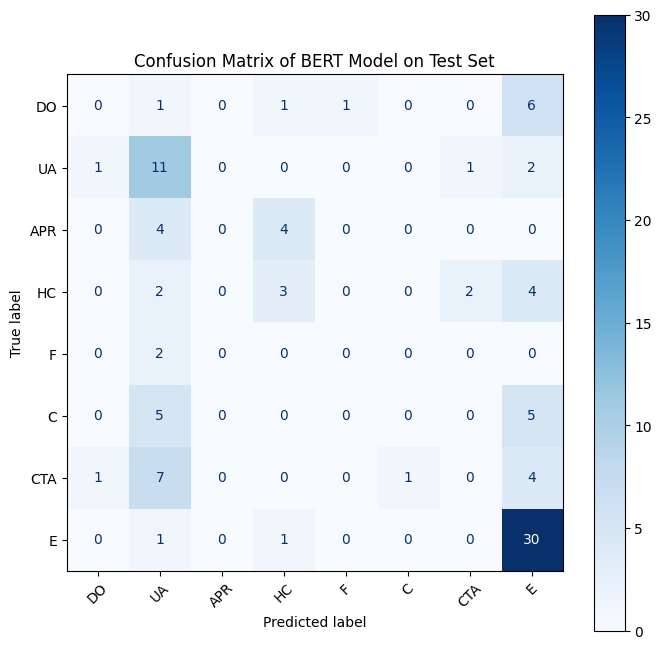

In [25]:
cm = confusion_matrix(all_trues, all_preds, labels=labels)
#print("Confusion Matrix: \n", confusion_matrix(all_trues, all_preds))
labels = list(set(all_trues))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))  # You can adjust figure size
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix of BERT Model on Test Set")
plt.show()

In [26]:
mistakes=[]
for i, (pred, true, prob_tensor) in enumerate(zip(all_preds, all_trues, all_probs)):
    pred_idx = label2id[pred]
    pred_confidence = prob_tensor[pred_idx].item()

    mistakes.append({
          "index": i,
          "confidence": pred_confidence,
          "true_label": true,
          "predicted_label": pred,
        })

mistakes = sorted(mistakes, key=lambda x: x["confidence"], reverse=False)

df = pd.DataFrame(mistakes)
df

,index,confidence,true_label,predicted_label
0,36,0.191346,CTA,DO
1,21,0.228537,DO,F
2,50,0.234401,APR,HC
3,61,0.249451,HC,CTA
4,6,0.255249,HC,E
...,...,...,...,...
95,99,0.913094,E,E
96,52,0.914008,E,E
97,63,0.914940,E,E
98,47,0.915618,E,E


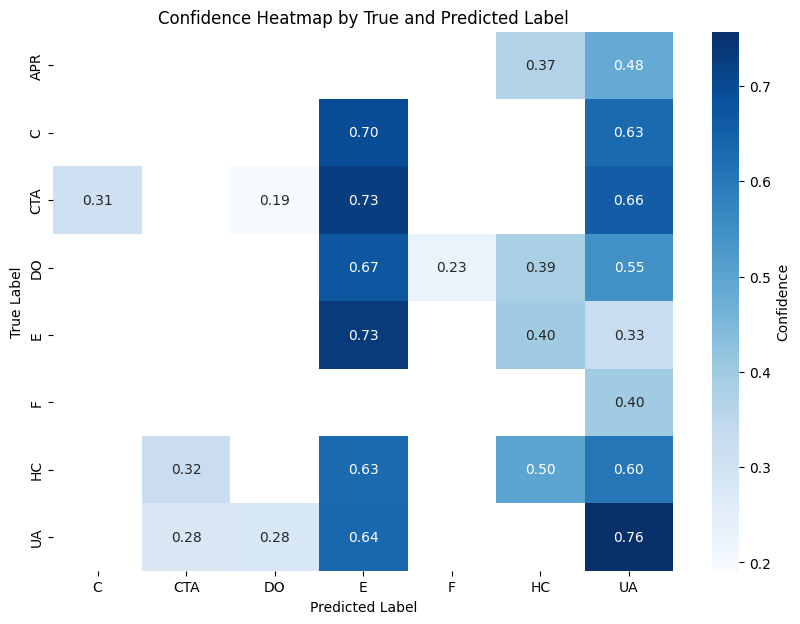

In [27]:
import seaborn as sns

# Convert confidence to float
df['confidence'] = df['confidence'].astype(float)

# Create a pivot table with true label as index, predicted label as columns, and confidence as values
heatmap_data = df.pivot_table(values='confidence', index='true_label', columns='predicted_label', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".2f", cbar_kws={'label': 'Confidence'})
plt.title('Confidence Heatmap by True and Predicted Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()